In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:21
🔁 Restarting kernel...


In [ ]:
!conda --version

conda 23.11.0


In [ ]:
!conda install -c conda-forge shenfun

In [ ]:
import numpy as np

In [ ]:
class KMM:
    """Navier Stokes channel flow solver in 2D

    The wall normal direction is along the x-axis, the streamwise along the y-axis.

    The solver is fully spectral with Chebyshev (or Legendre) in the wall-normal
    direction and Fourier in the other.

    Using the equations described by Kim, Moser, Moin (https://doi.org/10.1017/S0022112087000892)
    but with the spectral Galerkin method in space and a chosen time stepper.

    Parameters
    ----------
    N : 2-tuple of ints
        The global shape in physical space (quadrature points)
    domain : 2-tuple of 2-tuples
        The size of the three domains
    nu : Viscosity coefficient
    dt : Timestep
    conv : Choose convection method
        - 0 - Standard convection
        - 1 - Vortex type
    filename : str, optional
        Filenames are started with this name
    family : str, optional
        Chebyshev is normal, but Legendre works as well
    padding_factor : 2-tuple of numbers, optional
        For dealiasing, backward transforms to real space are
        padded with zeros in spectral space using these many points
    modplot : int, optional
        Plot some results every modplot timestep. If negative, no plotting
    modsave : int, optional
        Save results to hdf5 every modsave timestep.
    moderror : int, optional
        Print diagnostics every moderror timestep
    checkpoint : int, optional
        Save required data for restart to hdf5 every checkpoint timestep.
    timestepper : str, optional
        Choose timestepper

    Note
    ----
    Simulations may be killed gracefully by placing a file named 'killshenfun'
    in the folder running the solver from. The solver will then first store
    the results by checkpointing, before exiting.

    """
    def __init__(self,
                 N=(32, 32),
                 domain=((-1, 1), (0, 2*np.pi)),
                 nu=0.01,
                 dt=0.1,
                 conv=0,
                 dpdy=1,
                 filename='KMM',
                 family='C',
                 padding_factor=(1, 1.5),
                 modplot=100,
                 modsave=1e8,
                 moderror=100,
                 checkpoint=1000,
                 timestepper='IMEXRK222'):
        self.N = N
        self.nu = nu
        self.dt = dt
        self.conv = conv
        self.modplot = modplot
        self.modsave = modsave
        self.moderror = moderror
        self.filename = filename
        self.padding_factor = padding_factor
        self.dpdy = dpdy
        self.PDE = PDE = globals().get(timestepper)
        self.im1 = None

        # Regular spaces
        self.B0 = FunctionSpace(N[0], family, bc={'left': {'D': 0, 'N': 0}, 'right': {'D': 0, 'N': 0}}, domain=domain[0])
        self.D0 = FunctionSpace(N[0], family, bc=(0, 0), domain=domain[0])
        self.C0 = FunctionSpace(N[0], family, domain=domain[0])
        self.F1 = FunctionSpace(N[1], 'F', dtype='d', domain=domain[1])
        self.D00 = FunctionSpace(N[0], family, bc=(0, 0), domain=domain[0])  # Streamwise velocity, not to be in tensorproductspace
        self.C00 = self.D00.get_orthogonal()

        # Regular tensor product spaces
        self.TB = TensorProductSpace(comm, (self.B0, self.F1), modify_spaces_inplace=True) # Wall-normal velocity
        self.TD = TensorProductSpace(comm, (self.D0, self.F1), modify_spaces_inplace=True) # Streamwise velocity
        self.TC = TensorProductSpace(comm, (self.C0, self.F1), modify_spaces_inplace=True) # No bc
        self.BD = VectorSpace([self.TB, self.TD])  # Velocity vector space
        self.CD = VectorSpace(self.TD)             # Dirichlet vector space

        # Padded space for dealiasing
        self.TDp = self.TD.get_dealiased(padding_factor)

        self.u_ = Function(self.BD)      # Velocity vector solution
        self.H_ = Function(self.CD)      # convection
        self.ub = Array(self.BD)

        self.v00 = Function(self.D00)   # For solving 1D problem for Fourier wavenumber 0, 0
        self.w00 = Function(self.D00)

        self.work = CachedArrayDict()
        self.mask = self.TB.get_mask_nyquist() # Used to set the Nyquist frequency to zero
        self.X = self.TD.local_mesh(bcast=True)
        self.K = self.TD.local_wavenumbers(scaled=True)

        # Classes for fast projections. All are not used except if self.conv=0
        self.dudx = Project(Dx(self.u_[0], 0, 1), self.TD)
        if self.conv == 0:
            self.dudy = Project(Dx(self.u_[0], 1, 1), self.TB)
            self.dvdx = Project(Dx(self.u_[1], 0, 1), self.TC)
            self.dvdy = Project(Dx(self.u_[1], 1, 1), self.TD)

        self.curl = Project(curl(self.u_), self.TC)
        self.divu = Project(div(self.u_), self.TD)
        self.solP = None # For computing pressure

        # File for storing the results
        self.file_u = ShenfunFile('_'.join((filename, 'U')), self.BD, backend='hdf5', mode='w', mesh='uniform')

        # Create a checkpoint file used to restart simulations
        self.checkpoint = Checkpoint(filename,
                                     checkevery=checkpoint,
                                     data={'0': {'U': [self.u_]}})

        # set up equations
        v = TestFunction(self.TB)

        # Chebyshev matrices are not sparse, so need a tailored solver. Legendre has simply 5 nonzero diagonals and can use generic solvers.
        #sol1 = chebyshev.la.Biharmonic if self.B0.family() == 'chebyshev' else la.SolverGeneric1ND
        sol1 = la.SolverGeneric1ND

        self.pdes = {

            'u': PDE(v,                                   # test function
                     div(grad(self.u_[0])),               # u
                     lambda f: self.nu*div(grad(f)),      # linear operator on u
                     Dx(Dx(self.H_[1], 0, 1), 1, 1)-Dx(self.H_[0], 1, 2),
                     dt=self.dt,
                     solver=sol1,
                     latex=r"\frac{\partial \nabla^2 u}{\partial t} = \nu \nabla^4 u + \frac{\partial^2 N_y}{\partial x \partial y} - \frac{\partial^2 N_x}{\partial y^2}"),

        }

        # v. Solve divergence constraint for all wavenumbers except 0
        r""":math:`\nabla \cdot \vec{u} = 0`"""

        # v. Momentum equation for Fourier wavenumber 0
        if comm.Get_rank() == 0:
            v0 = TestFunction(self.D00)
            self.h1 = Function(self.D00)  # Copy from H_[1, :, 0, 0] (cannot use view since not contiguous)
            source = Array(self.C00)
            source[:] = -self.dpdy        # dpdy set by subclass
            sol = chebyshev.la.Helmholtz if self.B0.family() == 'chebyshev' else la.Solver
            self.pdes1d = {
                'v0': PDE(v0,
                          self.v00,
                          lambda f: self.nu*div(grad(f)),
                          [-Expr(self.h1), source],
                          dt=self.dt,
                          solver=sol,
                          latex=r"\frac{\partial v}{\partial t} = \nu \frac{\partial^2 v}{\partial x^2} - N_y - \frac{\partial p}{\partial y}"),
            }

    def convection(self):
        H = self.H_.v
        self.up = self.u_.backward(padding_factor=self.padding_factor)
        up = self.up.v
        if self.conv == 0:
            dudxp = self.dudx().backward(padding_factor=self.padding_factor).v
            dudyp = self.dudy().backward(padding_factor=self.padding_factor).v
            dvdxp = self.dvdx().backward(padding_factor=self.padding_factor).v
            dvdyp = self.dvdy().backward(padding_factor=self.padding_factor).v
            H[0] = self.TDp.forward(up[0]*dudxp+up[1]*dudyp, H[0])
            H[1] = self.TDp.forward(up[0]*dvdxp+up[1]*dvdyp, H[1])
            #H[1] = self.TDp.forward(up[0]*dvdxp-up[1]*dudxp, H[1])

        elif self.conv == 1:
            curl = self.curl().backward(padding_factor=self.padding_factor)
            H[0] = self.TDp.forward(-curl*up[1])
            H[1] = self.TDp.forward(curl*up[0])
        self.H_.mask_nyquist(self.mask)

    def compute_v(self, rk):
        u = self.u_.v
        if comm.Get_rank() == 0:
            self.v00[:] = u[1, :, 0].real
            self.h1[:] = self.H_[1, :, 0].real

        # Find velocity components v from div. constraint
        u[1] = 1j*self.dudx()/self.K[1]

        # Still have to compute for wavenumber = 0, 0
        if comm.Get_rank() == 0:
            # v component
            self.pdes1d['v0'].compute_rhs(rk)
            u[1, :, 0] = self.pdes1d['v0'].solve_step(rk)

        return u

    def compute_pressure(self):
        if self.solP is None:
            self.d2udx2 = Project(self.nu*Dx(self.u_[0], 0, 2), self.TC)
            N0 = self.N0 = FunctionSpace(self.N[0], self.B0.family(), bc={'left': {'N': self.d2udx2()}, 'right': {'N': self.d2udx2()}})
            TN = self.TN = TensorProductSpace(comm, (N0, self.F1), modify_spaces_inplace=True)
            #sol = chebyshev.la.Helmholtz if self.B0.family() == 'chebyshev' else la.SolverGeneric1ND
            sol = la.SolverGeneric1ND
            self.divH = Inner(TestFunction(TN), -div(self.H_))
            self.solP = sol(inner(TestFunction(TN), div(grad(TrialFunction(TN)))))
            self.p_ = Function(TN)

        self.d2udx2()
        self.N0.bc.update(update_tensor=True)
        p_ = self.solP(self.divH(), self.p_, constraints=((0, 0),))
        return p_

    def print_energy_and_divergence(self, t, tstep):
        if tstep % self.moderror == 0 and self.moderror > 0:
            ub = self.u_.backward(self.ub)
            e0 = inner(1, ub[0]*ub[0])
            e1 = inner(1, ub[1]*ub[1])
            divu = self.divu().backward()
            e3 = np.sqrt(inner(1, divu*divu))
            if comm.Get_rank() == 0:
                print("Time %2.5f Energy %2.6e %2.6e div %2.6e" %(t, e0, e1, e3))

    def init_from_checkpoint(self):
        self.checkpoint.read(self.u_, 'U', step=0)
        self.checkpoint.open()
        tstep = self.checkpoint.f.attrs['tstep']
        t = self.checkpoint.f.attrs['t']
        self.checkpoint.close()
        return t, tstep

    def initialize(self, from_checkpoint=False):
        if from_checkpoint:
            return self.init_from_checkpoint()
        raise RuntimeError('Initialize solver in subclass')

    def plot(self, t, tstep):
        pass

    def update(self, t, tstep):
        self.plot(t, tstep)
        self.print_energy_and_divergence(t, tstep)

    def tofile(self, tstep):
        self.file_u.write(tstep, {'u': [self.u_.backward(mesh='uniform')]}, as_scalar=True)

    def prepare_step(self, rk):
        self.convection()

    def assemble(self):
        for pde in self.pdes.values():
            pde.assemble()
        if comm.Get_rank() == 0:
            for pde in self.pdes1d.values():
                pde.assemble()

    def solve(self, t=0, tstep=0, end_time=1000):
        self.assemble()
        while t < end_time-1e-8:
            for rk in range(self.PDE.steps()):
                self.prepare_step(rk)
                for eq in self.pdes.values():
                    eq.compute_rhs(rk)
                for eq in self.pdes.values():
                    eq.solve_step(rk)
                self.compute_v(rk)
            t += self.dt
            tstep += 1
            self.update(t, tstep)
            self.checkpoint.update(t, tstep)
            if tstep % self.modsave == 0:
                self.tofile(tstep)

In [ ]:
from shenfun import *
import matplotlib.pyplot as plt
import sympy
import warnings

warnings.filterwarnings('ignore')

# pylint: disable=attribute-defined-outside-init

x, y, tt = sympy.symbols('x,y,t', real=True)

comm = MPI.COMM_WORLD

class RayleighBenard(KMM):

    def __init__(self,
                 N=(32, 32),
                 domain=((-np.pi, np.pi), (0, 2*np.pi)),
                 Ra=10000.,
                 Pr=0.7,
                 dt=0.1,
                 bcT=(0, 1),
                 conv=0,
                 filename='RB',
                 family='C',
                 padding_factor=(1, 1.5),
                 modplot=100,
                 modsave=1e8,
                 moderror=100,
                 checkpoint=1000,
                 timestepper='IMEXRK3'):
        KMM.__init__(self, N=N, domain=domain, nu=np.sqrt(Pr/Ra), dt=dt, conv=conv,
                     filename=filename, family=family, padding_factor=padding_factor,
                     modplot=modplot, modsave=modsave, moderror=moderror,
                     checkpoint=checkpoint, timestepper=timestepper, dpdy=0)
        self.kappa = 1./np.sqrt(Pr*Ra)
        self.bcT = bcT

        # Additional spaces and functions for Temperature equation
        self.T0 = FunctionSpace(N[0], family, bc=bcT, domain=domain[0])
        self.TT = TensorProductSpace(comm, (self.T0, self.F1), modify_spaces_inplace=True) # Temperature
        self.uT_ = Function(self.BD)     # Velocity vector times T
        self.T_ = Function(self.TT)      # Temperature solution
        self.Tb = Array(self.TT)

        self.file_T = ShenfunFile('_'.join((filename, 'T')), self.TT, backend='hdf5', mode='w', mesh='uniform')

        # Modify checkpoint file
        self.checkpoint.data['0']['T'] = [self.T_]

        dt = self.dt
        kappa = self.kappa

        # Chebyshev matrices are not sparse, so need a tailored solver. Legendre has simply 5 nonzero diagonals
        sol2 = chebyshev.la.Helmholtz if self.B0.family() == 'chebyshev' else la.SolverGeneric1ND

        # Addition to u equation.
        self.pdes['u'].N = [self.pdes['u'].N, Dx(self.T_, 1, 2)]
        self.pdes['u'].latex += r'\frac{\partial^2 T}{\partial y^2}'

        # Remove constant pressure gradient from v0 equation
        self.pdes1d['v0'].N = self.pdes1d['v0'].N[0]

        # Add T equation
        q = TestFunction(self.TT)
        self.pdes['T'] = self.PDE(q,
                                  self.T_,
                                  lambda f: kappa*div(grad(f)),
                                  -div(self.uT_),
                                  dt=self.dt,
                                  solver=sol2,
                                  latex=r"\frac{\partial T}{\partial t} = \kappa \nabla^2 T - \nabla \cdot \vec{u}T")

        self.im1 = None
        self.im2 = None

    def update_bc(self, t):
        # Update time-dependent bcs.
        self.T0.bc.update(t)
        self.T_.get_dealiased_space(self.padding_factor).bases[0].bc.update(t)

    def prepare_step(self, rk):
        self.convection()
        Tp = self.T_.backward(padding_factor=self.padding_factor)
        self.uT_ = self.up.function_space().forward(self.up*Tp, self.uT_)

    def tofile(self, tstep):
        self.file_u.write(tstep, {'u': [self.u_.backward(mesh='uniform')]}, as_scalar=True)
        self.file_T.write(tstep, {'T': [self.T_.backward(mesh='uniform')]})

    def init_from_checkpoint(self):
        self.checkpoint.read(self.u_, 'U', step=0)
        self.checkpoint.read(self.T_, 'T', step=0)
        self.checkpoint.open()
        tstep = self.checkpoint.f.attrs['tstep']
        t = self.checkpoint.f.attrs['t']
        self.checkpoint.close()
        return t, tstep

    def print_energy_and_divergence(self, t, tstep):
        if tstep % self.moderror == 0 and self.moderror > 0:
            ub = self.u_.backward(self.ub)
            Tb = self.T_.backward(self.Tb)
            e0 = inner(1, ub[0]*ub[0])
            e1 = inner(1, ub[1]*ub[1])
            d0 = inner(1, Tb*Tb)
            divu = self.divu().backward()
            e3 = np.sqrt(inner(1, divu*divu))
            if comm.Get_rank() == 0:
                if tstep % (10*self.moderror) == 0 or tstep == 0:
                    print(f"{'Time':^11}{'uu':^11}{'vv':^11}{'T*T':^11}{'div':^11}")
                print(f"{t:2.4e} {e0:2.4e} {e1:2.4e} {d0:2.4e} {e3:2.4e}")

    def initialize(self, rand=0.001, from_checkpoint=False):
        if from_checkpoint:
            self.checkpoint.read(self.u_, 'U', step=0)
            self.checkpoint.read(self.T_, 'T', step=0)
            self.checkpoint.open()
            tstep = self.checkpoint.f.attrs['tstep']
            t = self.checkpoint.f.attrs['t']
            self.checkpoint.close()
            self.update_bc(t)
            return t, tstep

        X = self.X
        funT = 1 if self.bcT[0] == 1 else 2
        fun = {1: 1,
               2: (0.9+0.1*np.sin(2*X[1]))}[funT]
        self.Tb[:] = 0.5*(1-X[0]+0.25*np.sin(np.pi*X[0]))*fun+rand*np.random.randn(*self.Tb.shape)*(1-X[0])*(1+X[0])
        self.T_ = self.Tb.forward(self.T_)
        self.T_.mask_nyquist(self.mask)
        return 0, 0

    def init_plots(self):
        self.ub = ub = self.u_.backward()
        Tb = self.T_.backward(self.Tb)
        if comm.Get_rank() == 0:
            plt.figure(1, figsize=(6, 3))
            #self.im1 = plt.quiver(self.X[1][::4, ::4], self.X[0][::4, ::4], ub[1, ::4, ::4], ub[0, ::4, ::4], pivot='mid', scale=0.01)
            self.im1 = plt.quiver(self.X[1][:, :], self.X[0][:, :], ub[1, :, :], ub[0, :, :], pivot='mid', scale=0.01)
            plt.draw()
            plt.figure(2, figsize=(6, 3))
            self.im2 = plt.contourf(self.X[1][:, :], self.X[0][:, :], Tb[:, :], 100)
            plt.draw()
            plt.pause(1e-6)

    def plot(self, t, tstep):
        if self.im1 is None and self.modplot > 0:
            self.init_plots()

        if tstep % self.modplot == 0 and self.modplot > 0:
            ub = self.u_.backward(self.ub)
            self.Tb = self.T_.backward(self.Tb)
            if comm.Get_rank() == 0:
                plt.figure(1)
                #self.im1.set_UVC(ub[1, ::4, ::4], ub[0, ::4, ::4])
                self.im1.set_UVC(ub[1, :, :], ub[0, :, :])
                self.im1.scale = np.linalg.norm(ub[1])
                plt.pause(1e-6)
                plt.figure(2)
                self.im2.axes.clear()
                self.im2.axes.contourf(self.X[1][:, :], self.X[0][:, :], self.Tb[:, :], 100)
                self.im2.autoscale()
                plt.pause(1e-6)

    def solve(self, t=0, tstep=0, end_time=1000):
        c = self.pdes['u'].stages()[2]
        self.assemble()
        while t < end_time-1e-8:
            for rk in range(self.PDE.steps()):
                self.prepare_step(rk)
                for eq in ['u', 'T']:
                    self.pdes[eq].compute_rhs(rk)
                for eq in ['u']:
                    self.pdes[eq].solve_step(rk)
                self.compute_v(rk)
                self.update_bc(t+self.dt*c[rk+1]) # modify time-dep boundary condition
                self.pdes['T'].solve_step(rk)
            t += self.dt
            tstep += 1
            if tstep%20==0:
              print(tstep)
            self.update(t, tstep)
            self.checkpoint.update(t, tstep)
            if tstep % self.modsave == 0:
                self.tofile(tstep)

/usr/local/lib/python3.10/site-packages/shenfun/optimization/numba/chebyshev.py:23: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _chebval(x, c, y, c0, c1, tmp, x2):
/usr/local/lib/python3.10/site-packages/shenfun/optimization/numba/__init__.py:201: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit(nopython=False, fastmath=True, cache=True)


In [ ]:
from time import time

# set parameters

N = (128,128)
d = {
    'N': N,
    'Ra': 10000.,
    'Pr': 0.7,
    'dt': 0.005,
    'filename': f'RB_{N[0]}_{N[1]}',
    'conv': 0,
    'modplot': 1e8,
    'moderror': 1e8,
    'modsave': 20, # save snapshots at an interval
    'bcT': (0.9+0.1*sympy.sin(2*(y-tt)), 0),
    #'bcT': (0.9+0.1*sympy.sin(2*y), 0),
    #'bcT': (0, 1),
    'family': 'C',
    'checkpoint': 20,
    #'padding_factor': 1,
    'timestepper': 'IMEXRK3'
    }
c = RayleighBenard(**d)
t, tstep = c.initialize(rand=0.001, from_checkpoint=True)
t0 = time()
c.solve(t=t, tstep=tstep, end_time=200)
if comm.Get_rank() == 0:
    generate_xdmf('_'.join((d['filename'], 'U'))+'.h5', order='visit')
    generate_xdmf('_'.join((d['filename'], 'T'))+'.h5', order='visit')
print('Computing time %2.4f'%(time()-t0))

In [ ]:
import h5py

# provide path to the file containing snapshots of temperature and velocities
filename = "RB_128_128_T.h5"
T_tensor = []
with h5py.File(filename, "r") as f:
    print(np.array(f['T']['2D']))
    for i in range(0,100,20):
      T_tensor.append(np.array(f['T']['2D'][str(i)]))


filename = "RB_128_128_U.h5"
u_x = []
u_y = []
with h5py.File(filename, "r") as f:
    for i in range(15400,32880,20):
      u_x.append(np.array(f['u0']['2D'][str(i)]))
      u_y.append(np.array(f['u1']['2D'][str(i)]))

In [ ]:
T_tensor = np.array(T_tensor)
u_x = np.array(u_x)
u_y = np.array(u_y)

timesteps = T_tensor.shape[0]
print(T.shape)
print(u_x.shape)
print(u_y.shape)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Truncate the earlier timesteps of the flow since its still developing

t_start = 1500

T_DNS = T_DNS[t_start:,:,:]
ux_DNS = ux_DNS[t_start:,:,:]
uy_DNS = uy_DNS[t_start:,:,:]

print(T_DNS.shape)
print(ux_DNS.shape)
print(uy_DNS.shape)

(1403, 256, 256)
(1403, 256, 256)
(1403, 256, 256)


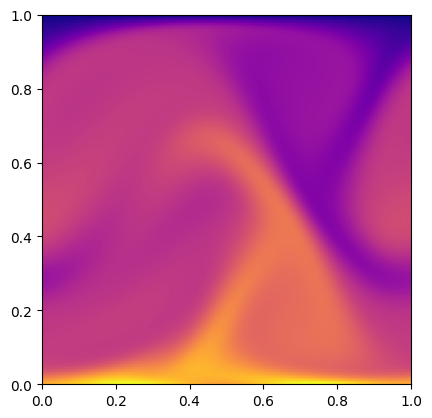

In [ ]:
import matplotlib.pyplot as plt

#plot the temperature profile at some timestep
p = plt.imshow(T_tensor[650,:,:], vmin=0, vmax=1, extent=[0, 1, 0, 1], aspect=1,
                cmap=plt.get_cmap('plasma'), origin='lower')
plt.show()

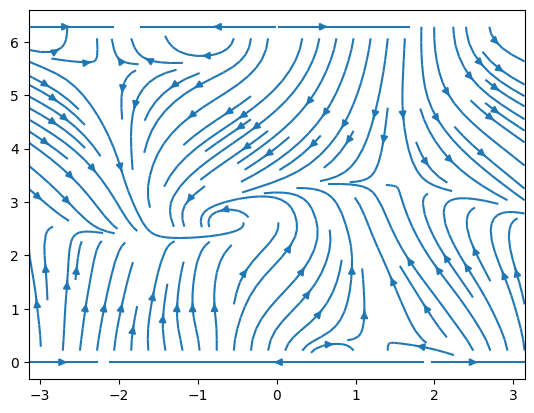

In [ ]:
# plot the streamlines of the flow at some timestep

import matplotlib.pyplot as plt

x = np.linspace(-np.pi, np.pi, 128)
y = np.linspace(0, 2*np.pi, 128)
xx, yy = np.meshgrid(x, y)

plt.streamplot(xx,yy,u_x[700,:,:],u_y[700,:,:])

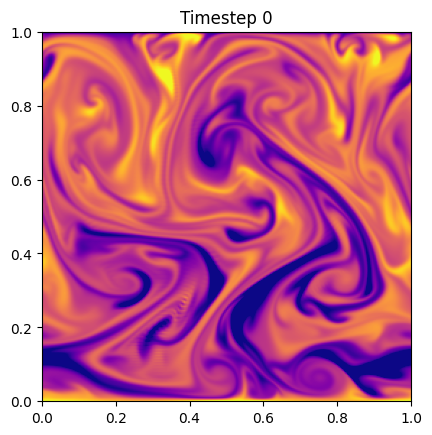

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


#create an animation for the temperature profile over time

timesteps = 201

arr = T_DNS_new

fig, ax = plt.subplots()
img = ax.imshow(arr[0,:,:],vmin=0,vmax=1,extent=[0,1,0,1],aspect=1,cmap=plt.get_cmap('plasma'),origin='lower',animated=True)

def update(frame):
    img.set_array(arr[frame,:, :])
    ax.set_title(f'Timestep {frame}')
    #cbar.mappable.set_clim(vmin=0,vmax=1)
    fig.canvas.draw()

frames = timesteps

animation = FuncAnimation(fig, update, frames=frames, interval=201, repeat=True)

animation.save('animation.mp4',writer='ffmpeg',fps=10)

In [ ]:
# Applying Gaussian Filtering to the Temperature and Velocity Fields

def coarse_spectral_filter_square_2DFHIT(a_hat, NCoarse):

    # Determine the size of the input array
    N = np.shape(a_hat)[0]

    # Compute the cutoff point in Fourier space
    dkcut= int(NCoarse[0]/2)

    # Define the start and end indices for the slice in Fourier space to keep
    ids = int(N/2)-dkcut
    ide = int(N/2)+dkcut

    # Shift the zero-frequency component to the center, then normalize the Fourier-transformed data
    a_hat_shift = np.fft.fftshift(a_hat)/(N**2)

    # Apply the spectral filter by slicing the 2D array
    wfiltered_hat_shift = a_hat_shift[ids:ide,ids:ide]

    # Shift the zero-frequency component back to the original place and un-normalize the data
    wfiltered_hat = np.fft.ifftshift(wfiltered_hat_shift)*(NCoarse[0]**2)

    # Return the filtered data
    return wfiltered_hat


def initialize_wavenumbers_2DFHIT(nx, ny, Lx, Ly, INDEXING='ij'):

    # Create an array of the discrete Fourier Transform sample frequencies in x-direction
    kx = 2 * np.pi * np.fft.fftfreq(nx, d=Lx/nx)

    # Create an array of the discrete Fourier Transform sample frequencies in y-direction
    ky = 2 * np.pi * np.fft.fftfreq(ny, d=Ly/ny)

    # Return coordinate grids (2D arrays) for the x and y wavenumbers
    (Kx, Ky) = np.meshgrid(kx, ky, indexing=INDEXING)

    # Compute the squared magnitudes of the 2D wavenumbers (Kx and Ky)
    Ksq = Kx ** 2 + Ky ** 2

    # Compute the absolute value of the wavenumbers
    Kabs = np.sqrt(Ksq)

    # To avoid division by zero, set the zero wavenumber to a large value
    Ksq[0,0] = 1e16

    # Compute the inverse of the squared wavenumbers
    invKsq = 1.0 / Ksq
    # Set the inverse of the zero wavenumber to zero
    invKsq[0,0] = 0.0

    # Set the zero wavenumber back to zero
    Ksq[0,0] = 0.0

    # Return the wavenumbers in the x and y directions, their absolute values,
    # their squared magnitudes and inverse of the squared magnitudes
    return Kx, Ky, Kabs, Ksq, invKsq


def filter2D_2DFHIT(U, filterType='gaussian', coarseGrainType='spectral', Delta=None, Ngrid=None, N_LES=None, spectral=False):

    # If Delta is not provided, compute it from Ngrid
    if Delta is None:
        if Ngrid is None:
            raise ValueError("Must provide either Delta or Ngrid")
        else:
            Delta = 2 * np.pi / Ngrid[0]

    # Fourier transform the input data if not already done
    if not spectral:
        U_hat = np.fft.fft2(U)
    else:
        U_hat = U

    # Get grid size in x and y directions
    NX_DNS, NY_DNS = np.shape(U_hat)
    Lx, Ly = 2 * np.pi, 2 * np.pi  # Domain size

    # Initialize wavenumbers for the DNS grid
    Kx_DNS, Ky_DNS, _, Ksq_DNS, _ = initialize_wavenumbers_2DFHIT(NX_DNS, NY_DNS, Lx, Ly, INDEXING='ij')

    # Apply filter to the data
    if filterType == 'gaussian':
        Gk = np.exp(-Ksq_DNS * (Delta ** 2) / 24)
        U_f_hat = Gk * U_hat

    elif filterType in ['box', 'boxSpectral']:
        Gkx = np.sinc(0.5 * Kx_DNS * Delta / np.pi)  # numpy's sinc includes pi factor
        Gky = np.sinc(0.5 * Ky_DNS * Delta / np.pi)
        Gkx[0, :] = 1.0
        Gky[:, 0] = 1.0
        Gk = Gkx * Gky
        U_f_hat = Gk * U_hat

    elif filterType == 'spectral' or filterType == 'spectral-circle':
        kc = Lx / (Delta)
        U_f_hat = spectral_filter_circle_same_size_2DFHIT(U_hat, kc)

    elif filterType == 'spectral-square':
        kc = Lx / (Delta)
        U_f_hat = spectral_filter_square_same_size_2DFHIT(U_hat, kc)

    elif filterType == None:
        U_f_hat = U_hat

    # Apply coarse graining
    if coarseGrainType == 'spectral':
        #N_LES = (100,100)
        U_f_c_hat = coarse_spectral_filter_square_2DFHIT(U_f_hat, N_LES)

    elif coarseGrainType == None:
        U_f_c_hat = U_f_hat

    # Inverse Fourier transform the result and return the real part
    if not spectral:
        return np.real(np.fft.ifft2(U_f_c_hat))
    else:
        return U_f_c_hat

In [ ]:
N_LES = (64,64)
N_DNS = (256,256)

T_hat = np.zeros((timesteps,N_LES[0],N_LES[0]))
ux_hat = np.zeros((timesteps,N_LES[0],N_LES[0]))
uy_hat = np.zeros((timesteps,N_LES[0],N_LES[0]))

for i in range(timesteps):
  #T_hat[i,:,:] = coarse_spectral_filter_square_2DFHIT(ahat=T_tensor[i,:,:], N_LES)
  T_hat[i,:,:] = filter2D_2DFHIT(T_DNS[i,:,:], filterType='gaussian', coarseGrainType='spectral', Ngrid=N_DNS,N_LES=N_LES, spectral=False)
  ux_hat[i,:,:] = filter2D_2DFHIT(ux_DNS[i,:,:], filterType='gaussian', coarseGrainType='spectral', Ngrid=N_DNS,N_LES=N_LES, spectral=False)
  uy_hat[i,:,:] = filter2D_2DFHIT(uy_DNS[i,:,:], filterType='gaussian', coarseGrainType='spectral', Ngrid=N_DNS,N_LES=N_LES, spectral=False)

In [ ]:
print(T_hat.shape)
print(ux_hat.shape)
print(uy_hat.shape)

(201, 64, 64)
(201, 64, 64)
(201, 64, 64)


In [ ]:
# Calculate the Sub-Grid Stress tensor (Tau)

uu = ux_DNS*ux_DNS
uv = ux_DNS*uy_DNS
vv = uy_DNS*uy_DNS

N_DNS = (256,256)
N_LES = (64,64)

Tau11 = np.zeros((timesteps,N_LES[0],N_LES[0]))
Tau12 = np.zeros((timesteps,N_LES[0],N_LES[0]))
Tau22 = np.zeros((timesteps,N_LES[0],N_LES[0]))

for i in range(timesteps):
  Tau11[i,:,:] = filter2D_2DFHIT(uu[i,:,:], filterType='gaussian', coarseGrainType='spectral', Ngrid=N_DNS,N_LES=N_LES, spectral=False) - ux_hat[i,:,:]*ux_hat[i,:,:]
  Tau12[i,:,:] = filter2D_2DFHIT(uv[i,:,:], filterType='gaussian', coarseGrainType='spectral', Ngrid=N_DNS,N_LES=N_LES, spectral=False) - ux_hat[i,:,:]*uy_hat[i,:,:]
  Tau22[i,:,:] = filter2D_2DFHIT(vv[i,:,:], filterType='gaussian', coarseGrainType='spectral', Ngrid=N_DNS,N_LES=N_LES, spectral=False) - uy_hat[i,:,:]*uy_hat[i,:,:]

In [ ]:
# Calculate the Sub-Grid Scalar Flux

uT = T_DNS*ux_DNS
vT = T_DNS*uy_DNS

sigma1 = np.zeros((timesteps,N_LES[0],N_LES[0]))
sigma2 = np.zeros((timesteps,N_LES[0],N_LES[0]))

for i in range(201):
  sigma1[i,:,:] = filter2D_2DFHIT(uT[i,:,:], filterType='gaussian', coarseGrainType='spectral', Ngrid=N_DNS,N_LES=N_LES, spectral=False) - T_hat[i,:,:]*ux_hat[i,:,:]
  sigma2[i,:,:] = filter2D_2DFHIT(vT[i,:,:], filterType='gaussian', coarseGrainType='spectral', Ngrid=N_DNS,N_LES=N_LES, spectral=False) - T_hat[i,:,:]*uy_hat[i,:,:]

In [ ]:
print(T_LES.shape)
print(ux_LES.shape)
print(Tau11.shape)
print(sigma1.shape)

(1499, 64, 64)
(1499, 64, 64)
(1499, 64, 64)
(1499, 64, 64)


In [ ]:
N_LES = (64,64)

trainN=160
valN=41
lead=1;
batch_size = 16
num_epochs = 100
pool_size = 2
drop_prob=0.0
conv_activation='relu'
Nlat = N_LES[0]
Nlon = N_LES[0]
n_channels=3
NT = 201

'\ninput_normalized=np.zeros([NT-300,Nlon, Nlat,n_channels],np.float32)\noutput_normalized=np.zeros([NT-300,Nlon,Nlat,5],np.float32)\n\n\ninput_normalized[0:NT-300,:,:,0] = T_hat[300:NT,:,:]\ninput_normalized[0:NT-300,:,:,1] = ux_hat[300:NT,:,:]\ninput_normalized[0:NT-300,:,:,2] = uy_hat[300:NT,:,:]\n\noutput_normalized[0:NT-300,:,:,0] = Tau11[300:NT,:,:]\noutput_normalized[0:NT-300,:,:,1] = Tau12[300:NT,:,:]\noutput_normalized[0:NT-300,:,:,2] = Tau22[300:NT,:,:]\noutput_normalized[0:NT-300,:,:,3] = sigma1[300:NT,:,:]\noutput_normalized[0:NT-300,:,:,4] = sigma2[300:NT,:,:]\n'

In [ ]:
# For TL

input_normalized=np.zeros([NT,Nlon, Nlat,n_channels],np.float32)
output_normalized=np.zeros([NT,Nlon,Nlat,5],np.float32)


input_normalized[0:NT,:,:,0] = T_hat[0:NT,:,:]
input_normalized[0:NT,:,:,1] = ux_hat[0:NT,:,:]
input_normalized[0:NT,:,:,2] = uy_hat[0:NT,:,:]

output_normalized[0:NT,:,:,0] = Tau11[0:NT,:,:]
output_normalized[0:NT,:,:,1] = Tau12[0:NT,:,:]
output_normalized[0:NT,:,:,2] = Tau22[0:NT,:,:]
output_normalized[0:NT,:,:,3] = sigma1[0:NT,:,:]
output_normalized[0:NT,:,:,4] = sigma2[0:NT,:,:]

In [ ]:
index=np.random.permutation(NT)
input_normalized=input_normalized[index,:,:,:]
output_normalized=output_normalized[index,:,:,:]

In [ ]:
input_normalized_val = input_normalized[trainN:,:,:,:]
output_normalized_val = output_normalized[trainN:,:,:,:]

input_normalized = input_normalized[0:trainN,:,:,:]
output_normalized = output_normalized[0:trainN,:,:,:]

In [ ]:
# save all the data into h5 files

with h5py.File('input_normalized.h5', 'w') as hf:
    hf.create_dataset("input_normalized",  data=input_normalized)

with h5py.File('input_normalized_val.h5', 'w') as hf:
    hf.create_dataset("input_normalized_val",  data=input_normalized_val)

with h5py.File('output_normalized.h5', 'w') as hf:
    hf.create_dataset("output_normalized",  data=output_normalized)

with h5py.File('output_normalized_val.h5', 'w') as hf:
    hf.create_dataset("output_normalized_val",  data=output_normalized_val)